# Introduction to TensorFlow and Keras

TensorFlow is Google's machine learning programing language. TensorFlow is a very general tools for constructing artificial neural networks, both as operation trees and as more topologically complicated networks. TensorFlow's nodes incorporate all of the structure we discussed in the lecture, including most importantly the reverse autodiff partial derivative information.

It's important to remember that using TensorFlow for computations proceeds in two parts:

1. __Construct a graph:__ In this step, create a pattern for the network by defining all of our nodes (input, output, constant, multipliers, LSUs, etc) and connecting them. You also specify their initial values. At this stage no construction has been done. 

2. __Instantiate the model:__ Start a tensor flow __session__ and instantiate the model. An instantiation of the neural network actually creates a copy of all the variables in memory and stores their initial values in them. I

3. __Running the graph:__  Within the TensorFlow __session__, begin running/training the network. 

<img src = "https://www.tensorflow.org/images/tensors_flowing.gif">

Higher level tools like Keras hide the details of the initialization and session and streamline this process by including pre-made versions of common architectures. 

This lab will consist of three parts: 

* __Part 1__: First, we will show how to create a simple computational tree using TensorFlow and how to run it using a session. 
* __Part 2__: Second, we will create a single layer perceptron with TensorFlow and use it to classify the binary labeling.
* __Part 3__: Finally, we will create a multilayer perceptron with TensorFlow and use it to classify the binary labeling.

#### Getting TensorFlow and Keras

If you are on Google Colab, TensorFlow and Keras are automatically installed. If you are running Jupyter locally use the anaconda prompt to install using 

    $ pip install tensorflow
$ pip install keras

* Windows: Open "Anaconda Prompt" from the start menu or from Cortana's search. 
* OSX: Open terminal, you should directly be able to use pip from there. 
* Linux: Open terminal, you should directly be able to use pip from there. 

For more information, see https://www.tensorflow.org/install and https://keras.io/#installation.

This lab follows Chapters 9 and 10 from *Hands-On Machine Learning with Scikit_Learn & TensorFlow*.

#### This notebook is based heavily on Geron's companion notebook

**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

This notebook can be found at 

https://github.com/ageron/handson-ml2

#### Lab 4.5: Tensorflow

This lab skips over Tensorflow and moves directly to using Keras to construct artificial neural networks. For an introduction to Tensorflow see Lab 4.5, which is not required. 

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and pretty them up a bit. Now that we've had some time to play around with pyplot, we will use matplotlib directly to set the font and label sizes globally. For more information about customization with rc see

https://matplotlib.org/3.1.3/tutorials/introductory/customizing.html

In [136]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('legend', fontsize=18)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

We will start by fitting a perceptron to some of the features of the UW Breast Cancer dataset. Loading the data below, we set our training data to the features we selected in Lab 3 as probably indicative of the labels.

Text(0,0.5,'concavity_mean')

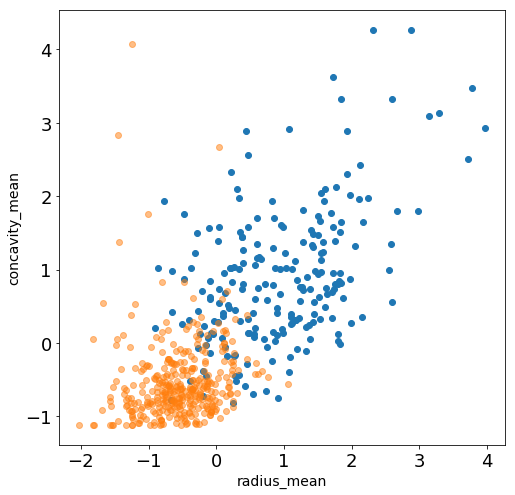

In [137]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data')
names = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean",
         "smoothness_mean","compactness_mean","concavity_mean","concave_points_mean",
         "symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se",
         "area_se","smoothness_se","compactness_se","concavity_se","concave" "points_se",
         "symmetry_se","fractal_dimension_se","radius_worst","texture_worst",
         "perimeter_worst","area_worst","smoothness_worst","compactness_worst",
         "concavity_worst","concave_points_worst","symmetry_worst","fractal_dimension_worst"]

data.columns=names


## Drop Feature Columns X
X = data.drop(columns=["id","diagnosis"])

## Set Up Target Variables y
y = data["diagnosis"]

## Normalize feature data by centering on the mean and dividing by std
X = (X - X.mean())/X.std()

f, ax = plt.subplots(figsize=(8,8))

I_m = y=="M"
I_b = y=="B"

plt.plot(X["radius_mean"][I_m],X["concavity_mean"][I_m],'o',label="Malignant")

## We set alpha=.5 to try to avoid masking, but some points still will be burried. 
plt.plot(X["radius_mean"][I_b],X["concavity_mean"][I_b],'o',label="Benign",alpha=.5)

plt.xlabel("radius_mean")
plt.ylabel("concavity_mean")

Now, we need to import Tensorflow and Keras. Within Keras, a perceprton is just what is called a __dense layer__, this is because the multicategory perceptron has a single weight for each connection between the input later and the output layer:

<img width = 50% src="https://github.com/tipthederiver/Math-7243-2020/raw/master/Labs/Lab%204/Lab4MultilabPerceptron.PNG">

To code this in keras, we need to specify five things:

* The dimension of the input.
* The dimension of the output.
* The activation function for the LTUs.
* The loss function. 
* The training method, or the optimizer.

This kind of model is a __sequential model__ since the data starts at one end and passes through to the other end which each layer acting on all of the data. As such, we start by creating a sequential model using `keras.models.Sequential()` and then adding a `Dense` layer as below. Since the dense layer is an input layer, we will need to specify the input size the dense lay should expect, in this case 2:

* `keras.layers.Dense(2,[input_dim=2,] activation="relu")` Create a layer densely connecting to all nodes in the layer before it. If this is the input layer, specify the dimensionality of the input. 

In this case we will have two input dimensions (__radius_mean__ and __concavity_mean__) and 2 output dimensions (__M__ and __B__).

In [138]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Dense(2,input_dim=2, activation="relu"))

We can see a summary of the model we've built by using `model.summary`, include the number of parameters:

In [139]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


These six parameters are the four weights in the $2\times 2$ weight matrix, plus the two bias $B$ parameters:

$$
\hat{y} = \sigma(WX + B)\,,
$$

where $\sigma$ here is the ReLU function acting on each coordinate separately. To compile the model, we run `model.compile()`. We need to specify the __loss__, and the __optimizer__. We can also optionally specify a __metric__ that will be reported so that we can evaluate the model, but will not be used in training.

* `model.compile(loss=, optimizer= [,metric=[] ])` - Compile the model with the given loss function, optimize and metrics.

In this case we will use __categorical cross entropy__ as our loss: 
$$
L(y,\hat{y}) = 
$$
The categorical cross entropy

In [140]:
model.compile(loss="mean_squared_error",
              optimizer="sgd",
              metrics=["accuracy"])

And now we fit the model. We will have sklearn perform the train set split for us:

In [141]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[["radius_mean","concavity_mean"]], 
                                                    pd.get_dummies(y), 
                                                    test_size=0.2, 
                                                    random_state=42)

In [142]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_test, y_test))

Train on 454 samples, validate on 114 samples
Epoch 1/20
454/454 [==============================] - 0s 519us/step - loss: 0.7353 - acc: 0.1432 - val_loss: 0.6955 - val_acc: 0.1667
Epoch 2/20
454/454 [==============================] - 0s 26us/step - loss: 0.6700 - acc: 0.1586 - val_loss: 0.6445 - val_acc: 0.1754
Epoch 3/20
454/454 [==============================] - 0s 35us/step - loss: 0.6227 - acc: 0.1762 - val_loss: 0.6076 - val_acc: 0.2018
Epoch 4/20
454/454 [==============================] - 0s 46us/step - loss: 0.5881 - acc: 0.1960 - val_loss: 0.5800 - val_acc: 0.2193
Epoch 5/20
454/454 [==============================] - 0s 44us/step - loss: 0.5623 - acc: 0.2048 - val_loss: 0.5604 - val_acc: 0.2632
Epoch 6/20
454/454 [==============================] - 0s 42us/step - loss: 0.5438 - acc: 0.2203 - val_loss: 0.5442 - val_acc: 0.2807
Epoch 7/20
454/454 [==============================] - 0s 42us/step - loss: 0.5289 - acc: 0.2379 - val_loss: 0.5311 - val_acc: 0.3158
Epoch 8/20
454/454 [==

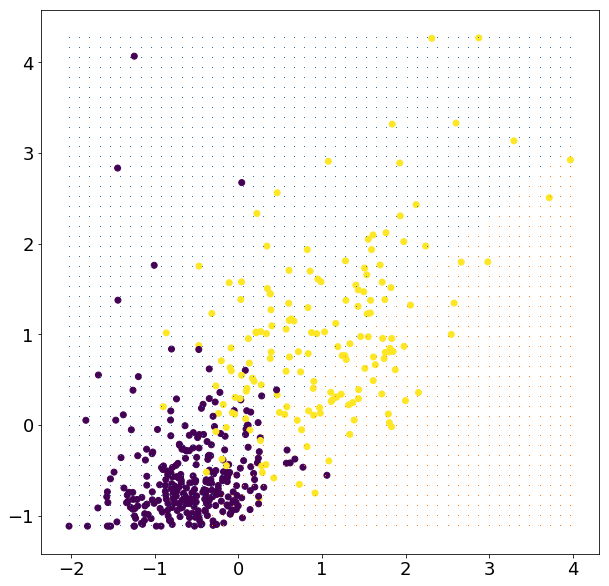

In [143]:
fig = plt.figure(figsize=(10,10))

N = 50

x_mesh = np.linspace(X_train.radius_mean.min(), X_train.radius_mean.max(), N)
y_mesh = np.linspace(X_train.concavity_mean.min(), X_train.concavity_mean.max(), N)
[XX,YY] = np.meshgrid(x_mesh,y_mesh)
XX = XX.reshape(-1,1)
YY = YY.reshape(-1,1)

D = np.concatenate([XX,YY],axis=1)
ZZ = np.argmax(model.predict(D),axis=1)

plt.plot(XX[ZZ==0],YY[ZZ==0],',')
plt.plot(XX[ZZ==1],YY[ZZ==1],',')
plt.scatter(X_train.radius_mean,X_train.concavity_mean,c=np.argmax(np.array(y_train),axis=1))

It may take a few more epochs then expected, but the perceptron does eventually find a good classifier. 

#### Exercise:

In the network above, we had to choose the loss function, the activation function for the LTU and the optimizer. These are not the only choices we could have made. For example, for activation function we have chosen

Loss Functions (https://keras.io/losses/)
* `mean_squared_error`: The standard RSS error for numerical data $L(y,\hat{y})= \frac{1}{N}\sum_{i=1}^N (y-\hat{y})^2$.
* `mean_absolute_error`: The absolute error for numerical data $L(y,\hat{y}) = \frac{1}{N}\sum_{i=1}^N |y-\hat{y}|$.
* `categorical_crossentropy:`The categorical cross entropy
$$
L(y,\hat{y}) = -\sum_{i=1}^N \sum_{k=1}^K y_{ik}\,\log(\hat{y}_{ik})\,.
$$
    The categorical cross entropy assume the values are probabilities, and so take values between 0 and 1. 
    
Activation Functions (https://keras.io/activations/)

* `relu`: The ReLU function, used for regression problems. 
$$(x)_+ = \begin{cases}0&x<0\,,\\x&x\geq0\,.\end{cases}$$
* `tanh`: The hyperbolic tangent function with values between -1 and 1. Used for regression. 
* `sigmoid`: The binary sigmoid activation with values between 0 and 1. Used for binary classification $\sigma(x) = \frac{1}{1 + e^{-x}}$.
* `softmax`: The softmax function converts a vector of values into approximate probability for each element of the vectors. Used in multicategory classification: $\sigma:\mathbb{R}^K\to\mathbb{R}^K$, via
$$
\sigma(x)_k = \frac{e^{-x_k}}{\sum_{k=1}^K e^{-x_k}}
$$

Try the functions above in the network. Why would you expect `softmax` to work better with `categorical_crossentropy`?

### A first deep network:

Deepening our network is as simple as adding another dense layer on, although now we can specify the number of nodes in the internal layer. In the code below, we insert a hidden layer with 10 nodes. We still have an input of 2 and and output of 2, keras works out the connections for the intermediate layers. 

In [144]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Dense(10,input_dim=2, activation="relu"))
model.add(keras.layers.Dense(2,input_dim=2, activation="relu"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 22        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


#### Exercise: 

We now have 52=$2\times 10 + 10 + 10\times 2 + 2$ parameters. Why?

If you want to install pydot, the network can be visualized with

In [131]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

we can now compile, train and visualize the deep network:

In [145]:
model.compile(loss="mean_squared_error",
              optimizer="sgd",
              metrics=["accuracy"])

In [151]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_test, y_test))

Train on 454 samples, validate on 114 samples
Epoch 1/20
454/454 [==============================] - 0s 29us/step - loss: 0.0673 - acc: 0.9141 - val_loss: 0.1044 - val_acc: 0.8596
Epoch 2/20
454/454 [==============================] - 0s 29us/step - loss: 0.0670 - acc: 0.9141 - val_loss: 0.1039 - val_acc: 0.8596
Epoch 3/20
454/454 [==============================] - 0s 29us/step - loss: 0.0668 - acc: 0.9185 - val_loss: 0.1032 - val_acc: 0.8596
Epoch 4/20
454/454 [==============================] - 0s 29us/step - loss: 0.0664 - acc: 0.9185 - val_loss: 0.1029 - val_acc: 0.8596
Epoch 5/20
454/454 [==============================] - 0s 31us/step - loss: 0.0663 - acc: 0.9185 - val_loss: 0.1024 - val_acc: 0.8596
Epoch 6/20
454/454 [==============================] - 0s 48us/step - loss: 0.0660 - acc: 0.9185 - val_loss: 0.1019 - val_acc: 0.8684
Epoch 7/20
454/454 [==============================] - 0s 48us/step - loss: 0.0658 - acc: 0.9185 - val_loss: 0.1013 - val_acc: 0.8684
Epoch 8/20
454/454 [===

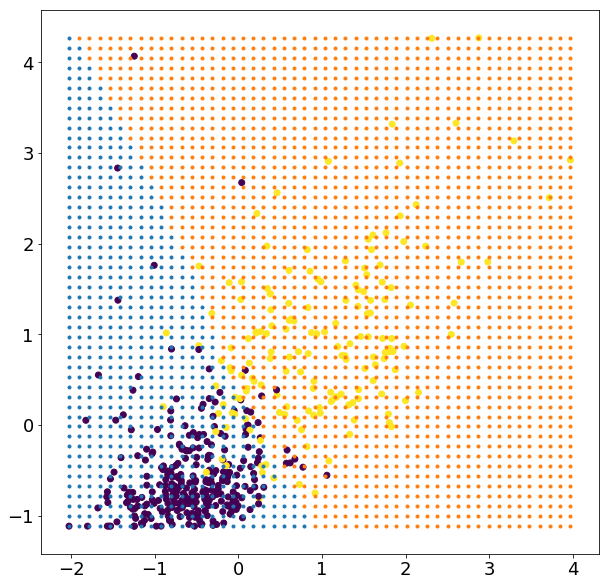

In [152]:
fig = plt.figure(figsize=(10,10))

N = 50

x_mesh = np.linspace(X_train.radius_mean.min(), X_train.radius_mean.max(), N)
y_mesh = np.linspace(X_train.concavity_mean.min(), X_train.concavity_mean.max(), N)
[XX,YY] = np.meshgrid(x_mesh,y_mesh)
XX = XX.reshape(-1,1)
YY = YY.reshape(-1,1)

D = np.concatenate([XX,YY],axis=1)
ZZ = np.argmax(model.predict(D),axis=1)

plt.plot(XX[ZZ==0],YY[ZZ==0],'.')
plt.plot(XX[ZZ==1],YY[ZZ==1],'.')
plt.scatter(X_train.radius_mean,X_train.concavity_mean,c=np.argmax(np.array(y_train),axis=1))

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [155]:
import tensorflow as tf
from tensorflow import keras

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [156]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [157]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [158]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [159]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

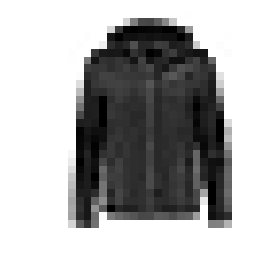

In [160]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [161]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [162]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [163]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [164]:
X_valid.shape

(5000, 28, 28)

In [165]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

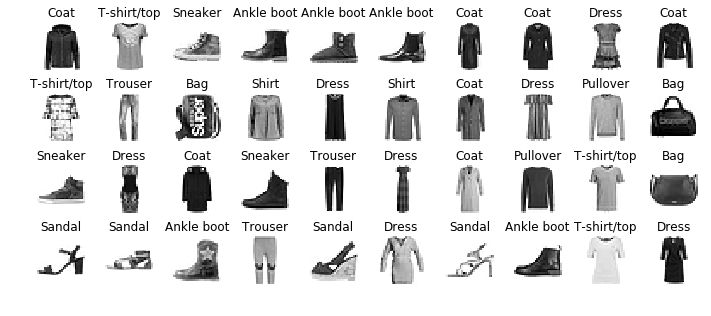

In [166]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Just as before, we want to construct a model to classify the images. Since each of the images is $28\times 28$, we have two options: 

1. We can reshape the images as we have before and use an input layer with 784 inputs.
2. We can add a `keras.layers.Flatten` layer to our network with an input shape of `[28,28]` and let is reshape the data for us.

We will use the latter method. 

In [182]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

Lets take a look at our model:

In [183]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [172]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

`model` itself is an object containing all of network information. For example, if we would like information about the layers we can query them from the `model.layers`. For example:

In [184]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [185]:
model.get_layer(hidden1.name) is hidden1

True

We can also dump the weights and biases if we so wish, using each layers `layer.get_weights()` function.

In [186]:
weights, biases = hidden1.get_weights()

In [187]:
weights

array([[ 0.00161628,  0.01932339, -0.02565089, ..., -0.00291944,
        -0.02012116,  0.01593321],
       [ 0.003511  ,  0.00166138, -0.05111507, ..., -0.05969467,
         0.07066816, -0.06677708],
       [ 0.00250675, -0.04420146, -0.06725983, ...,  0.00825078,
         0.06031603,  0.04145714],
       ...,
       [ 0.05493028,  0.06783485,  0.07423182, ...,  0.00960991,
         0.05428734, -0.03733533],
       [-0.06818426,  0.0315909 ,  0.04394099, ..., -0.06186718,
        -0.03296133, -0.06185633],
       [ 0.05747883,  0.00992823,  0.04587641, ..., -0.07271924,
        -0.02785959, -0.04018621]], dtype=float32)

In [188]:
weights.shape

(784, 300)

In [34]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [189]:
biases.shape

(300,)

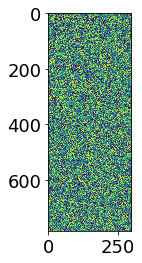

In [192]:
plt.imshow(weights)

Lets compile and fit the model.

In [193]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [194]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 61us/step - loss: 0.6992 - acc: 0.7666 - val_loss: 0.5021 - val_acc: 0.8316
Epoch 2/30
55000/55000 [==============================] - 4s 64us/step - loss: 0.4866 - acc: 0.8303 - val_loss: 0.4380 - val_acc: 0.8532
Epoch 3/30
55000/55000 [==============================] - 4s 77us/step - loss: 0.4430 - acc: 0.8450 - val_loss: 0.4331 - val_acc: 0.8488
Epoch 4/30
55000/55000 [==============================] - 3s 58us/step - loss: 0.4155 - acc: 0.8533 - val_loss: 0.3985 - val_acc: 0.8662
Epoch 5/30
55000/55000 [==============================] - 3s 56us/step - loss: 0.3954 - acc: 0.8608 - val_loss: 0.3872 - val_acc: 0.8638
Epoch 6/30
55000/55000 [==============================] - 4s 68us/step - loss: 0.3796 - acc: 0.8652 - val_loss: 0.3958 - val_acc: 0.8630
Epoch 7/30
55000/55000 [==============================] - 4s 75us/step - loss: 0.3662 - acc: 0.8706 - val_loss: 0.3595 - val_acc:

## Tracking training:

Now that we've trained out model, we can use the `history` object we saved our training model into to track the training. The history has all of the parameters we passed to the trainer in `history.params`

In [196]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': None,
 'samples': 55000,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc'],
 'validation_steps': None}

It also has any metrics we may have been using stored in for each epoch. 

(0, 1)

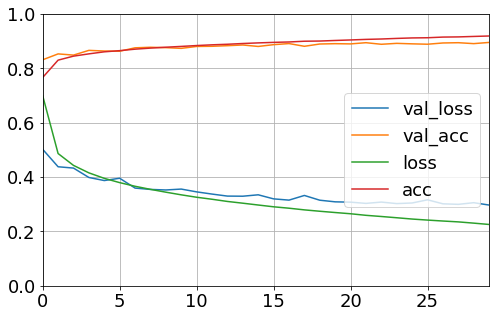

In [201]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 1)

We can evaluate the model using the evaluate function. This will return the any metrics we specified at the time of the function call:

In [202]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 29us/step


[0.3274185398161411, 0.8817]

Finally, as before we can use our model to predict the label on new data:

In [43]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [44]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [45]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [46]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


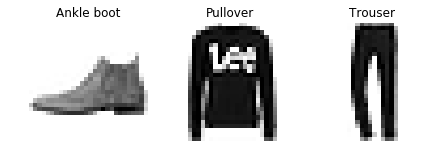

In [47]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Saving and Restoring

Now that we've done trained our network, we want to save the weights out for future use. We can save our model out with

* `model.save("my_keras_model.h5")` - Saves keras model as "my_keras_model.h5".

We can load it back in later with

* `model = keras.models.load_model("my_keras_model.h5")` - Load model from saved model file. 

We can also checkpoint a model by saving or loading just the weights. This allows us to keep several versions of the model during training:

* `model.save_weights("my_keras_weights.ckpt")` - Save model weights.
* `model.load_weights("my_keras_weights.ckpt")` - Load model weights.

In [68]:
model.save("my_keras_model.h5")

In [71]:
model.save("my_keras_model.h5")

In [72]:
model = keras.models.load_model("my_keras_model.h5")

In [73]:
model.predict(X_valid[0,:,:])

array([[0.551559 ],
       [1.6555369],
       [3.0014234]], dtype=float32)

In [74]:
model.save_weights("my_keras_weights.ckpt")

In [75]:
model.load_weights("my_keras_weights.ckpt")

# Extra: Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

For the next two sections, Geron uses the California Housing Dataset included with Keras. The code below loads and scales the data. 

In [206]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

As usual, we will set a random seed for reproducibility. If Tensorflow throws an error feel free to comment out the second line. 

In [204]:
np.random.seed(42)
tf.random.set_seed(42)

AttributeError: module 'tensorflow._api.v1.random' has no attribute 'set_seed'

This time the network will not be strict sequential. Instead we have an __input__ layer, feeding into 30 node dense layer called __hidden1__, which in turn feeds into a 30 node dense layer called __hidden2__. This is where the network becomes non-sequential: We then concatenate both __hidden2__ and __input__ into a single layer __concat__ that contains the data of both. Finally, we the densely connect __concat__ to the single parameter output (the cost of the house). 

$$
\begin{matrix}
&&\textbf{hidden1}&\rightarrow &\textbf{hidden2} \\
&\nearrow&&&&\searrow\\
\textbf{input} &&\longrightarrow &&\longrightarrow&&\textbf{concat} &\rightarrow \textbf{output}
\end{matrix}
$$

We can see here that we are _jumping layers,_ not simply connecting each layer to the one after. This is an example of __non-sequential__ neural network. We will talk more about how different topologies can effect to the training speed and accuracy of our model, but for now we will just be playing around with a few different topologies. 

In [207]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [208]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           930         dense_3[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_4[0][0]                    
__________

In [210]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 44us/step - loss: 0.4102 - val_loss: 0.4205
Epoch 2/20
11610/11610 [==============================] - 0s 26us/step - loss: 0.4069 - val_loss: 0.4127
Epoch 3/20
11610/11610 [==============================] - 0s 28us/step - loss: 0.4044 - val_loss: 0.4185
Epoch 4/20
11610/11610 [==============================] - 0s 29us/step - loss: 0.4018 - val_loss: 0.3813
Epoch 5/20
11610/11610 [==============================] - 0s 36us/step - loss: 0.3987 - val_loss: 0.4084
Epoch 6/20
11610/11610 [==============================] - 0s 35us/step - loss: 0.3965 - val_loss: 0.3793
Epoch 7/20
11610/11610 [==============================] - 0s 24us/step - loss: 0.3942 - val_loss: 0.4247
Epoch 8/20
11610/11610 [==============================] - 0s 26us/step - loss: 0.3919 - val_loss: 0.3991
Epoch 9/20
11610/11610 [==============================] - 0s 27us/step - loss: 0.3898 - val_loss: 0.3789
Epoch 

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [205]:
np.random.seed(42)
tf.random.set_seed(42)

AttributeError: module 'tensorflow._api.v1.random' has no attribute 'set_seed'

#### Exercise:

Analyze the network constructed below and draw it's topology.

In [211]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [212]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 50us/step - loss: 2.0584 - val_loss: 2.0590
Epoch 2/20
11610/11610 [==============================] - 0s 38us/step - loss: 0.7830 - val_loss: 0.9415
Epoch 3/20
11610/11610 [==============================] - 0s 31us/step - loss: 0.6880 - val_loss: 0.6583
Epoch 4/20
11610/11610 [==============================] - 0s 27us/step - loss: 0.6412 - val_loss: 0.6236
Epoch 5/20
11610/11610 [==============================] - 0s 27us/step - loss: 0.6095 - val_loss: 0.5641
Epoch 6/20
11610/11610 [==============================] - 0s 27us/step - loss: 0.5820 - val_loss: 0.5903
Epoch 7/20
11610/11610 [==============================] - 0s 28us/step - loss: 0.5607 - val_loss: 0.5154
Epoch 8/20
11610/11610 [==============================] - 0s 28us/step - loss: 0.5405 - val_loss: 0.5258
Epoch 9/20
11610/11610 [==============================] - 0s 30us/step - loss: 0.5230 - val_loss: 0.5093
Epoch 

## Regularizing:

Adding an auxiliary output for regularization: We saw in the case of ridge and lasso regression that often we can regularize the model by penalizing the weights. In this case we form two outputs, one directly from the layer __hidden2__ and one from the concatenated layer __concat__. Effectively, we are training two loss functions at the same time on a different parts of the same network. This has the potential in large networks to drastically speed training, by having one loss function fixing main large layers, and another loss function fine tuning smaller, in between layers. 

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

In [213]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [214]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [215]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 77us/step - loss: 2.4670 - main_output_loss: 2.2905 - aux_output_loss: 4.0561 - val_loss: 3.2918 - val_main_output_loss: 3.3107 - val_aux_output_loss: 3.1223
Epoch 2/20
11610/11610 [==============================] - 0s 29us/step - loss: 0.9993 - main_output_loss: 0.8347 - aux_output_loss: 2.4808 - val_loss: 0.9659 - val_main_output_loss: 0.8302 - val_aux_output_loss: 2.1874
Epoch 3/20
11610/11610 [==============================] - 0s 31us/step - loss: 0.7964 - main_output_loss: 0.6751 - aux_output_loss: 1.8877 - val_loss: 0.9001 - val_main_output_loss: 0.7743 - val_aux_output_loss: 2.0327
Epoch 4/20
11610/11610 [==============================] - 0s 31us/step - loss: 0.7118 - main_output_loss: 0.6118 - aux_output_loss: 1.6119 - val_loss: 0.7822 - val_main_output_loss: 0.6512 - val_aux_output_loss: 1.9610
Epoch 5/20
11610/11610 [==============================] - 0s 33us/step - lo

In [64]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

5160/5160 [==============================] - 0s 19us/sample - loss: 0.4656 - main_output_loss: 0.4165 - aux_output_loss: 0.9111


# Extra: Using Callbacks during Training

After each epoch, keras returns a loss, accuracy, validation loss and validation accuracy, as well as other metrics we may specify. However, sometimes you want more information: a confusion matrix, an example of the output, a "worst offenders" list, or something else. Callback functions allow us to have Keras return information to us each epoch. 

For example, Keras doesn't have an inbuilt function to return the ratio of the (log of the) validation loss to the (log of the) training loss. In the code below, Geron implements a function

In [216]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [218]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/1
 9376/11610 [=======================>......] - ETA: 0s - loss: 2.4771
val/train: 0.66
11610/11610 [==============================] - 1s 52us/step - loss: 2.2137 - val_loss: 1.4503


# Problems:

### Problem 1: 

Train a deep MLP on the MNIST dataset (you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

### Problem 2:

Train a deep neural network on the MRI slices dataset. Try to get demonstrably better accuracy than classifying everything as the same label. In this case, it may be helpful to _restrict_ the number of trainable parameters, sacrificing bias for reduction in variance. 